# Gal's Notes
- Preprocess Data - DONE
- Split to train, val, test - DONE
- Visualize - DONE
- Resize images - DONE
- Augment images - DONE
- Create model - DONE
- Train model - DONE
- Differentiate over/under fitting - DONE
- Evaluate model - DONE

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-09 17:50:27.734951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Data Loading

In [8]:
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, as_supervised=True, shuffle_files=True, split=["train"], data_dir="./data/"
)

2024-04-09 17:36:56.202520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:36:56.206521: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:36:56.206544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:36:56.209462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 17:36:56.209484: I external/local_xla/xla/stream_executor

## Data Splitting (Train / Val / Test)

In [10]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [11]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(
    dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO
)

## Visualize data

2024-04-09 17:37:28.751881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


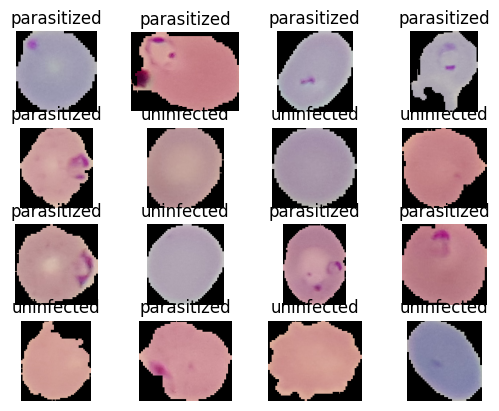

In [12]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i + 1)

    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

# Resize and Rescale

In [13]:
IM_SIZE = 224

def resize_and_rescale(image, label):
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE])
    image = image / 255.0
    return (image, label)

# Augment Data

In [14]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # maybe add other random augmentations
    return image, label

In [15]:
def preprocess(image, label):
    image, label = resize_and_rescale(image, label)
    image, label = augment(image, label)
    return image, label

In [16]:
new_train_dataset = train_dataset.map(preprocess)
new_val_dataset = val_dataset.map(resize_and_rescale)
new_test_dataset = test_dataset.map(resize_and_rescale)

# Create train / val / test datasets (shuffled with batch sizes)

In [18]:
BATCH_SIZE = 32
new_train_dataset = (
    new_train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
new_val_dataset = (
    new_val_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
new_test_dataset = (
    new_test_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# LeNet

In [20]:
lenet_model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
        Conv2D(
            filters=10,
            kernel_size=3,
            strides=1,
            padding="valid",
            activation="relu",
            # kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        # Dropout(rate=0.1),
        Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="valid",
            activation="relu",
            # kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        # Dropout(rate=0.1),
        Flatten(),
        Dense(
            100,
            activation="relu",
            # kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        # Dropout(rate=0.1),
        Dense(
            10,
            activation="relu",
            # kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)

lenet_model.compile(
    optimizer="adam",
    loss=BinaryCrossentropy(),
    metrics=["accuracy"],
)

callbacks_list = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        restore_best_weights=True,
    )
]
history = lenet_model.fit(new_train_dataset, epochs=10, validation_data=new_val_dataset, callbacks=callbacks_list, verbose=1,)

Epoch 1/3


I0000 00:00:1712684367.062384   12243 service.cc:145] XLA service 0x7f8d58003290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712684367.062418   12243 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-04-09 17:39:27.114067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 17:39:27.326053: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 10/689 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6019 - loss: 0.7395

I0000 00:00:1712684369.984626   12243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.7201 - loss: 0.5459 - val_accuracy: 0.8947 - val_loss: 0.2579
Epoch 2/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9142 - loss: 0.2312 - val_accuracy: 0.8287 - val_loss: 0.5796
Epoch 3/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9189 - loss: 0.2179 - val_accuracy: 0.9238 - val_loss: 0.2448


In [20]:
lenet_model.save("models/lenet_model.h5", save_format="h5")

# Visualize loss and accuracy

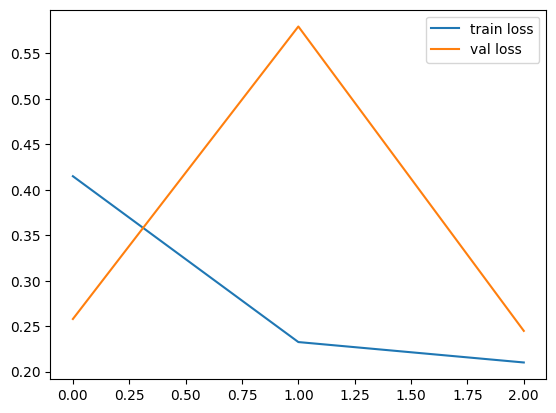

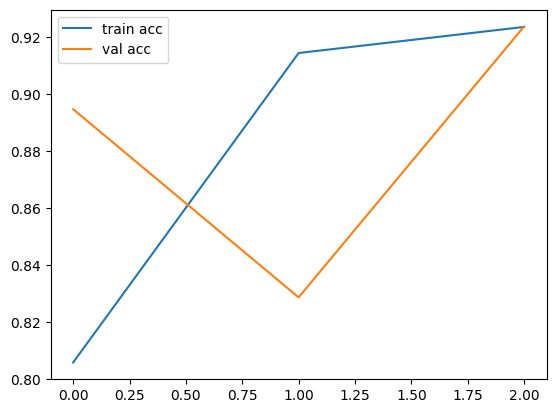

In [21]:
def plot_history(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.legend()
    plt.show()

    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.legend()
    plt.show()


plot_history(history)

# Evaluate

In [23]:
rounds = 3
avg_score = 0
for i in range(rounds):
    avg_score += lenet_model.evaluate(new_test_dataset)[1]
print(avg_score / rounds)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9120 - loss: 0.2854
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9060 - loss: 0.3199
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9110 - loss: 0.3024
0.9077499707539877


## Confusion matrix

In [24]:
preds = []
labels = []
for image, label in new_test_dataset:
    preds.append(lenet_model(image))
    labels.append(label.numpy())
preds = np.array(preds[:-1]).flatten()
labels = np.array(labels[:-1]).flatten()
print(preds.shape)
print(labels.shape)

(2752,)
(2752,)


2024-04-09 17:41:12.808156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[[ 982  409]
 [   8 1353]]


Text(70.72222222222221, 0.5, 'Predicted')

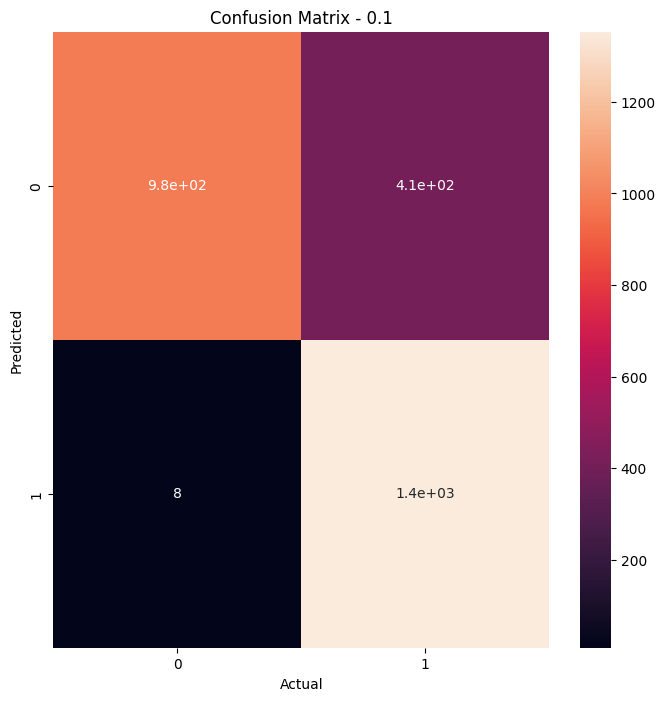

In [25]:
threshold = 0.1
cm = confusion_matrix(labels, preds > threshold)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix - {threshold}")
plt.xlabel("Actual")
plt.ylabel("Predicted")